## The Goal: read in data from previous simulations with CLUBB output (monthly) detailing wind variance and skewness. Save a few time averages out as pickle files for easier manipulation. 
Author: Meg D. Fowler <br>
Date: 10 Aug 2020<br><br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
from datetime import date, timedelta
import pandas as pd 



## Read in data

In [2]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
#dataDir   = '/glade/work/mdfowler/data/CLUBB_sim/'   # on Casper/Cheyenne 
nameStart = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd   = '_CLUBBwinds.nc'

decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.zeros([len(lat),len(lon)])
landMask[landFrac > 0.5] = 1


**Plot land mask to make sure this <i>is</i> what I wanted**

Text(0.5, 1.0, 'Land Mask (Sanity Check)')

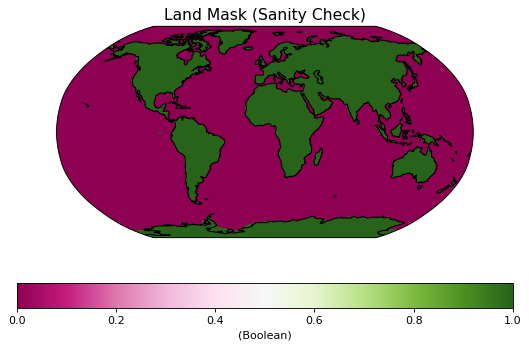

In [99]:
# Plot land mask
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
landMask_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(landMask, lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,landMask_cyclic,cmap='PiYG',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title('Land Mask (Sanity Check)', fontsize=14)


**Now start <i>actually</i> reading in data**

In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


    PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
    presDF = xr.open_dataset(PSfile, decode_times=True)
    presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-4-319b86f5c9c1>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-319b86f5c9c1>:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


Since ideally, I'd like to be able to access the time attributes fairly easily, I'm going to put those into a separate pandas array.<br> That way they can be indexed via dates.year, dates.month, etc. <br> 
    
Note: monthly averages are saved at the first time step of the <i>next</i> month. So to get January averages for example, you'd want dates.month==2. <br>

In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 


## Look at some statistics 

In [6]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB      # Third moment vertical velocity (m3/s3)
PS  = fullPS.PS             # Surface pressure (Pa)

np.shape(WP3)

(768, 33, 192, 288)

In [7]:
# Take (annual) time means to look at a few PDFs 
UP2_timeMean = np.squeeze(np.nanmean(UP2, 0))
VP2_timeMean = np.squeeze(np.nanmean(VP2, 0))
WP2_timeMean = np.squeeze(np.nanmean(WP2, 0))
WP3_timeMean = np.squeeze(np.nanmean(WP3, 0))


In [8]:
# --- Compare to seasonal means --- #
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]

# DJF 
UP2_DJFmean = np.squeeze(np.nanmean(UP2[iDJF,:,:,:], 0))
VP2_DJFmean = np.squeeze(np.nanmean(VP2[iDJF,:,:,:], 0))
WP2_DJFmean = np.squeeze(np.nanmean(WP2[iDJF,:,:,:], 0))
WP3_DJFmean = np.squeeze(np.nanmean(WP3[iDJF,:,:,:], 0))
print('Done with DJF means')

# MAM 
UP2_MAMmean = np.squeeze(np.nanmean(UP2[iMAM,:,:,:], 0))
VP2_MAMmean = np.squeeze(np.nanmean(VP2[iMAM,:,:,:], 0))
WP2_MAMmean = np.squeeze(np.nanmean(WP2[iMAM,:,:,:], 0))
WP3_MAMmean = np.squeeze(np.nanmean(WP3[iMAM,:,:,:], 0))
print('Done with MAM means')

# JJA
UP2_JJAmean = np.squeeze(np.nanmean(UP2[iJJA,:,:,:], 0))
VP2_JJAmean = np.squeeze(np.nanmean(VP2[iJJA,:,:,:], 0))
WP2_JJAmean = np.squeeze(np.nanmean(WP2[iJJA,:,:,:], 0))
WP3_JJAmean = np.squeeze(np.nanmean(WP3[iJJA,:,:,:], 0))
print('Done with JJA means')

# SON
UP2_SONmean = np.squeeze(np.nanmean(UP2[iSON,:,:,:], 0))
VP2_SONmean = np.squeeze(np.nanmean(VP2[iSON,:,:,:], 0))
WP2_SONmean = np.squeeze(np.nanmean(WP2[iSON,:,:,:], 0))
WP3_SONmean = np.squeeze(np.nanmean(WP3[iSON,:,:,:], 0))
print('Done with SON means')


Done with DJF means
Done with MAM means
Done with JJA means
Done with SON means


### PDFs

In [136]:
# Specify some parameters for histograms 
UP2_bins     = np.linspace(4.0e-4, 4.03e-4, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
UP2_binCount = np.full([6, len(UP2_bins)-1], np.nan)
UP2_binWidth = (UP2_bins[1]-UP2_bins[0])/2
UP2_binCent  = UP2_bins[1::] - UP2_binWidth


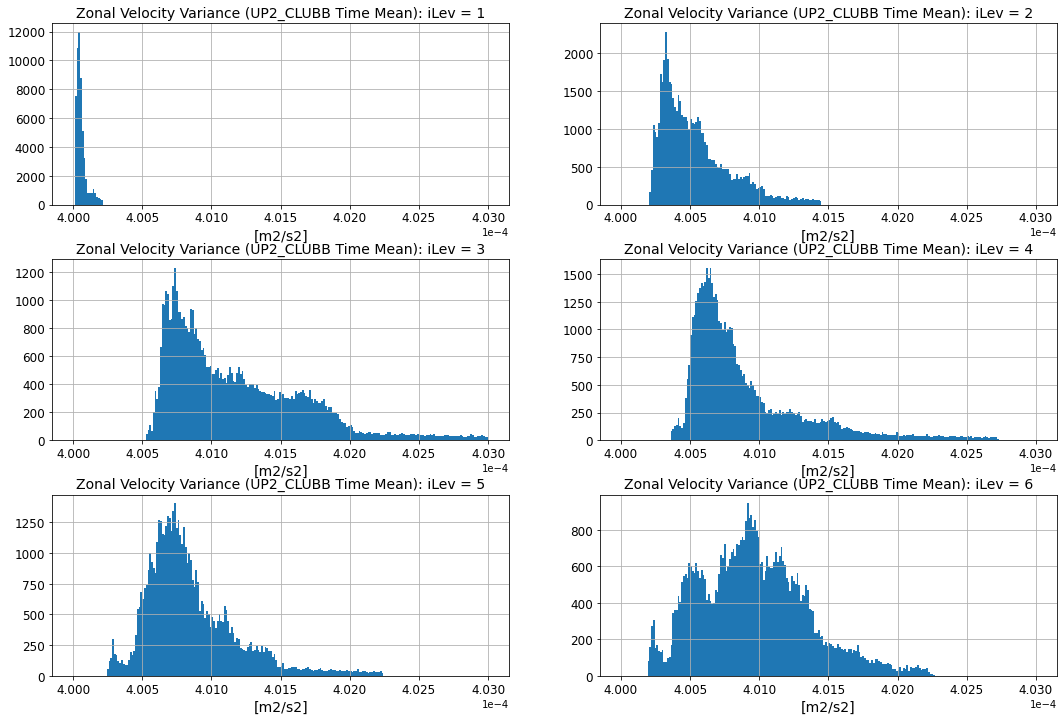

In [137]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    # Reshape data into 1D array
    UP2_reshape = np.squeeze(UP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    n, bins, patches = axs[iLev].hist(UP2_reshape,bins=UP2_bins)
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1400])
    axs[iLev].set_title('Zonal Velocity Variance (UP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)

    UP2_binCount[iLev,:] = n 
    

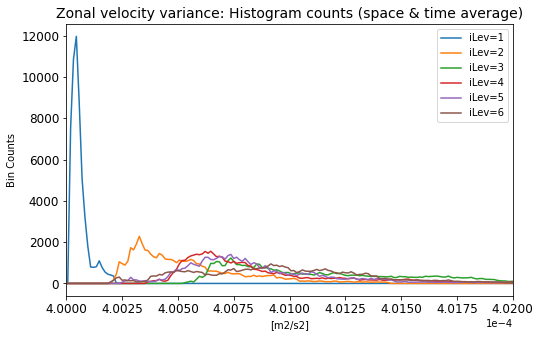

In [138]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

for iLev in range(6):
    ax1.plot(UP2_binCent,UP2_binCount[iLev,:],'-')  # Plot bin counts by level 
    
ax1.legend(['iLev=1','iLev=2','iLev=3','iLev=4','iLev=5','iLev=6'])   # Add legend 
ax1.set_title('Zonal velocity variance: Histogram counts (space & time average)', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0)) # Use scientific notation on x-axis
ax1.set_xlabel('[m2/s2]')        # Add labels to axes 
ax1.set_ylabel('Bin Counts')
ax1.set_xlim([4.0e-4, 4.02e-4])  # Zoom in on the x-axis to more clearly see differences
ax1.tick_params(labelsize=12)    # Set tick font size 



Can we break the y-axis to show this all a bit better? See documentation here, which I've mostly copied and pasted from: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html

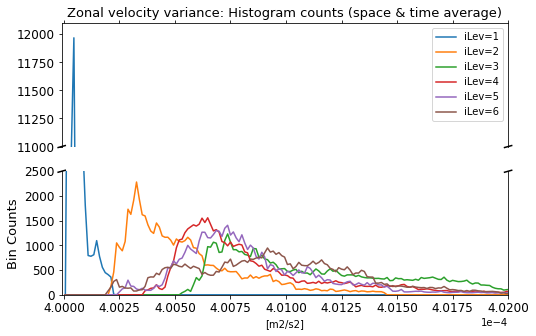

In [157]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

# Plot same data on each axis 
for iLev in range(6):
    ax1.plot(UP2_binCent,UP2_binCount[iLev,:],'-')  # Plot bin counts by level 
    ax2.plot(UP2_binCent,UP2_binCount[iLev,:],'-')  # Plot bin counts by level 

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(11000, 12100)  # outliers only
ax2.set_ylim(0, 2500)      # Most of the data 

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .008  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


# All my regular plot settings 
ax1.legend(['iLev=1','iLev=2','iLev=3','iLev=4','iLev=5','iLev=6'])   # Add legend 
ax1.set_title('Zonal velocity variance: Histogram counts (space & time average)', fontsize=13)
ax2.ticklabel_format(style='sci',axis='x',scilimits=(0,0)) # Use scientific notation on x-axis
ax2.set_xlabel('[m2/s2]')        # Add labels to axes 
ax2.set_ylabel('Bin Counts',fontsize=13)
ax2.set_xlim([3.9999e-4, 4.02e-4])  # Zoom in on the x-axis to more clearly see differences
ax2.tick_params(labelsize=12)    # Set tick font size 
ax1.tick_params(labelsize=12)    # Set tick font size 


plt.show()


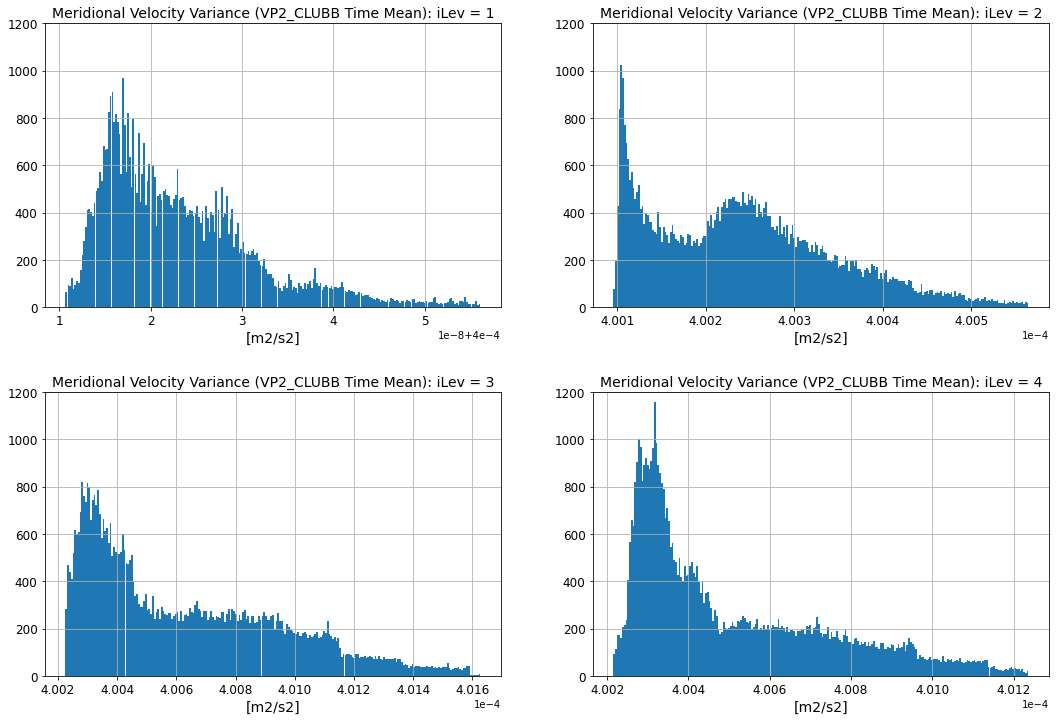

In [236]:
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(4):
    # Reshape data into 1D array
    VP2_reshape = np.squeeze(VP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(VP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Meridional Velocity Variance (VP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)



In [291]:
# Investigate vertical velocity variance at low levels... 

for iLev in range(len(fullDF.ilev)):
    print('iLev = ', iLev)
    print('   Min: %.6e' % np.nanmin(WP2_timeMean[iLev,:,:]))
    print('   Max: %.6e' % np.nanmax(WP2_timeMean[iLev,:,:]))
    print('   Std: %.6e' % np.nanstd(WP2_timeMean[iLev,:,:]))
    print()


iLev =  0
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  1
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  2
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  3
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  4
   Min: 4.000038e-04
   Max: 4.000055e-04
   Std: 8.792993e-11

iLev =  5
   Min: 4.000038e-04
   Max: 4.001482e-04
   Std: 1.230011e-09

iLev =  6
   Min: 4.000038e-04
   Max: 4.023003e-04
   Std: 1.922614e-08

iLev =  7
   Min: 4.000038e-04
   Max: 4.324008e-04
   Std: 2.156382e-07

iLev =  8
   Min: 4.000038e-04
   Max: 4.436664e-04
   Std: 4.959466e-07

iLev =  9
   Min: 4.000038e-04
   Max: 1.339964e-03
   Std: 1.169868e-05

iLev =  10
   Min: 4.000038e-04
   Max: 5.596205e-03
   Std: 1.020608e-04

iLev =  11
   Min: 4.000038e-04
   Max: 8.489895e-03
   Std: 5.899000e-04

iLev =  12
   Min: 4.000038e-04
   Max: 2.296943e-02
   Std: 2.109883e-03

iLev =  13
   Min: 4.000038e-04
   

So at the lowest model levels, there's no spatial variability in the time mean of vertical velocity variance. Just constant. Start at iLev=4, start to see *some* differences, but not a ton.

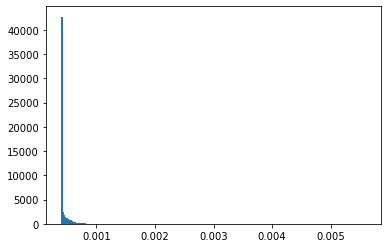

In [292]:
iLev = 10
WP2_reshape = np.squeeze(WP2_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))

plt.hist(WP2_reshape,bins=np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
plt.show()

In [9]:
# Investigate vertical velocity skew at low levels... 

for iLev in range(len(fullDF.ilev)):
    print('iLev = ', iLev)
    print('   Min: %.6e' % np.nanmin(WP3_timeMean[iLev,:,:]))
    print('   Max: %.6e' % np.nanmax(WP3_timeMean[iLev,:,:]))
    print('   Std: %.6e' % np.nanstd(WP3_timeMean[iLev,:,:]))
    print()


iLev =  0
   Min: 0.000000e+00
   Max: 0.000000e+00
   Std: 0.000000e+00

iLev =  1
   Min: -1.449707e-10
   Max: -1.354785e-10
   Std: 2.399343e-12

iLev =  2
   Min: -7.692935e-10
   Max: -7.528423e-10
   Std: 3.857588e-12

iLev =  3
   Min: -6.456944e-10
   Max: -6.242742e-10
   Std: 6.827342e-12

iLev =  4
   Min: -1.026298e-09
   Max: -5.291975e-10
   Std: 1.039722e-11

iLev =  5
   Min: -1.397465e-08
   Max: 1.091166e-07
   Std: 5.319062e-10

iLev =  6
   Min: -1.337216e-07
   Max: 4.902747e-06
   Std: 2.557026e-08

iLev =  7
   Min: -6.800974e-06
   Max: 1.634346e-06
   Std: 3.755424e-08

iLev =  8
   Min: -2.575509e-06
   Max: 2.265565e-05
   Std: 3.487917e-07

iLev =  9
   Min: -2.108700e-05
   Max: 6.445087e-04
   Std: 1.286012e-05

iLev =  10
   Min: -2.348935e-05
   Max: 3.764399e-03
   Std: 1.213709e-04

iLev =  11
   Min: -3.782699e-04
   Max: 1.399835e-02
   Std: 7.623575e-04

iLev =  12
   Min: -3.151857e-04
   Max: 5.731335e-02
   Std: 3.420987e-03

iLev =  13
   Min: 

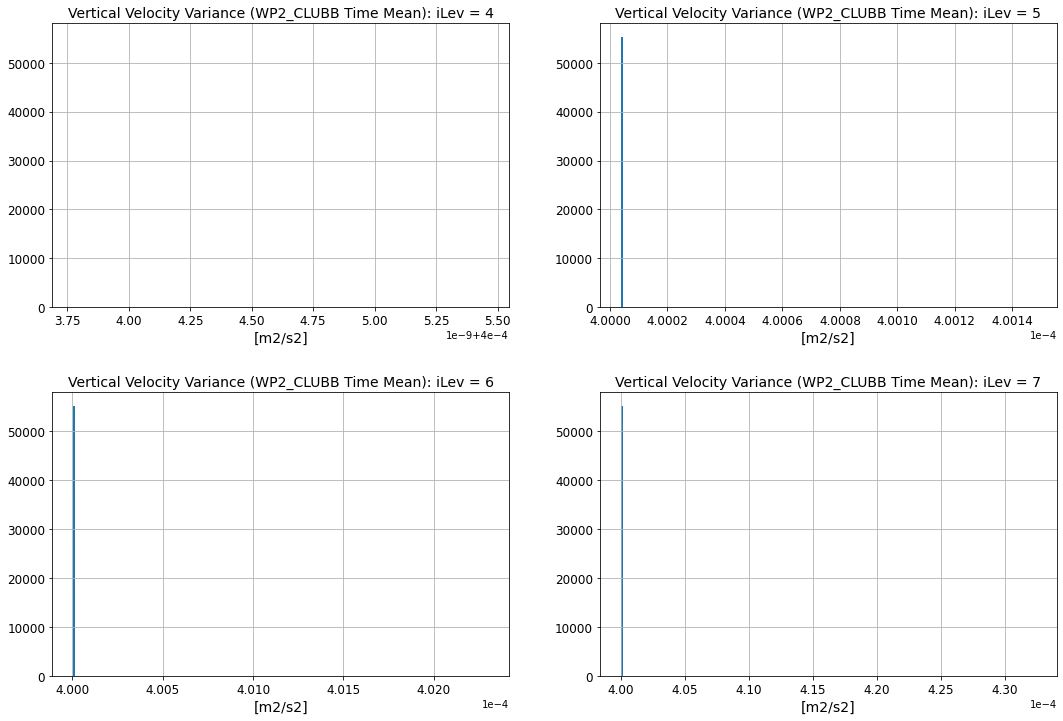

In [17]:
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(4):
    levSel = iLev+4
    
    # Reshape data into 1D array
    WP2_reshape = np.squeeze(WP2_timeMean[levSel,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(WP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Vertical Velocity Variance (WP2_CLUBB Time Mean): iLev = '+str(levSel), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)



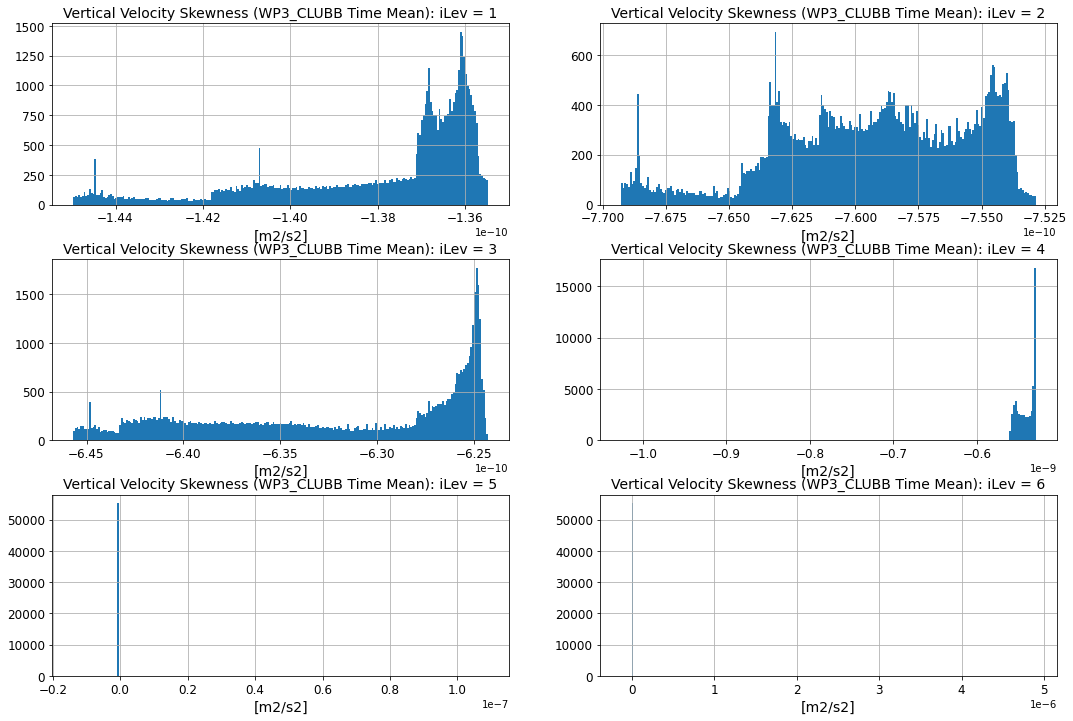

In [19]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    levSel = iLev+1
    
    # Reshape data into 1D array
    WP3_reshape = np.squeeze(WP3_timeMean[levSel,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(WP3_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Vertical Velocity Skewness (WP3_CLUBB Time Mean): iLev = '+str(levSel), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)


In [293]:
# fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .3,wspace = 0.2)
# axs = axs.ravel()

# for iLev in range(4):
#     # Reshape data into 1D array
#     WP2_reshape = np.squeeze(WP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
#     # Plot histogram
#     axs[iLev].hist(WP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
#     axs[iLev].grid()
#     #axs[iLev].set_ylim([0,1200])
#     axs[iLev].set_title('Vertical Velocity Variance (WP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
#     axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
#     axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
#     axs[iLev].tick_params(labelsize=12)


#### Seasonality

Let's start with looking at the zonal velocity variance by season. Does the global mean change?

In [185]:
# Specify level of interest
iLev = 3

print('Min at level: %5.4e' % (np.nanmin(UP2_timeMean[iLev,:,:])))
print('Max at level: %5.4e' % (np.nanmax(UP2_timeMean[iLev,:,:])))


Min at level: 4.0053e-04
Max at level: 4.0311e-04


In [186]:
# Specify some parameters for histograms 
UP2seasonal_bins     = np.linspace(4.005e-4, 4.032e-4, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
UP2seasonal_binCount = np.full([4, len(UP2seasonal_bins)-1], np.nan)
UP2seasonal_binWidth = (UP2seasonal_bins[1]-UP2seasonal_bins[0])/2
UP2seasonal_binCent  = UP2seasonal_bins[1::] - UP2seasonal_binWidth


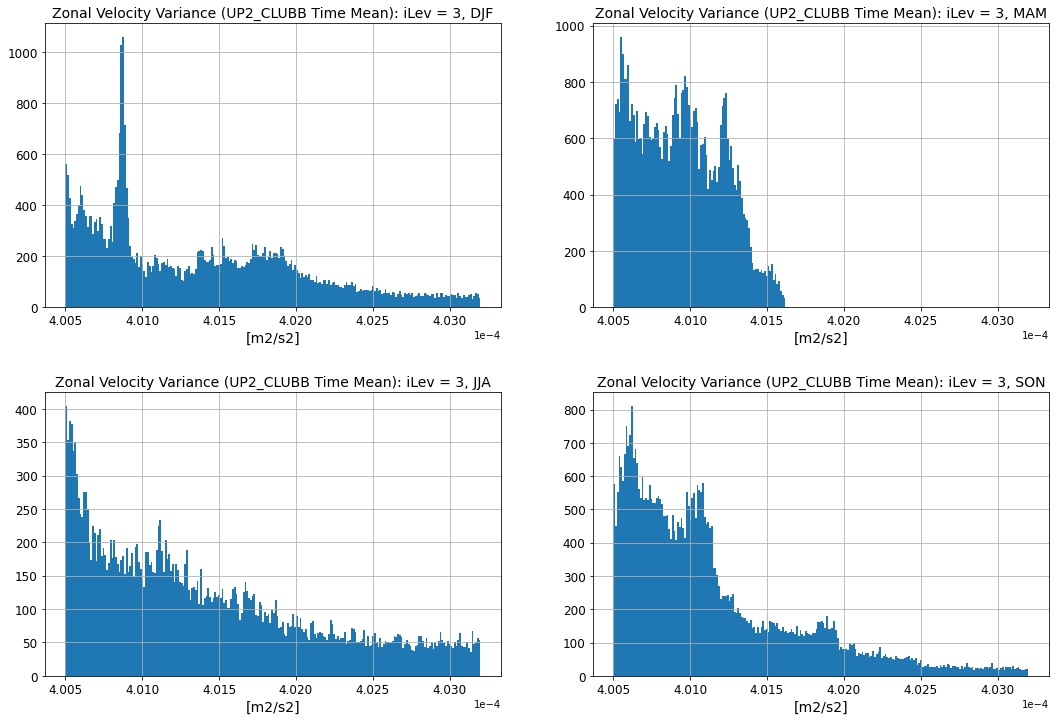

In [187]:
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

# Specify level of interest
#iLev = 2

# Reshape arrays into 1D for making histogram easier 
reshape_DJF = np.squeeze(UP2_DJFmean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
reshape_MAM = np.squeeze(UP2_MAMmean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
reshape_JJA = np.squeeze(UP2_JJAmean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
reshape_SON = np.squeeze(UP2_SONmean[iLev,:,:]).reshape((len(lat)*len(lon), 1))

# Plot each histogram 
for iSeason in range(4):
    if iSeason==0:
        nDJF, bins, patches = axs[iSeason].hist(reshape_DJF,bins=UP2seasonal_bins)
        season = 'DJF'
    elif iSeason==1:
        nMAM, bins, patches = axs[iSeason].hist(reshape_MAM,bins=UP2seasonal_bins)
        season='MAM'
    elif iSeason==2:
        nJJA, bins, patches = axs[iSeason].hist(reshape_JJA,bins=UP2seasonal_bins)
        season='JJA'
    elif iSeason==3: 
        nSON, bins, patches = axs[iSeason].hist(reshape_SON,bins=UP2seasonal_bins)
        season='SON'

    axs[iSeason].grid()
    #axs[iSeason].set_ylim([0,1800])
    axs[iSeason].set_title('Zonal Velocity Variance (UP2_CLUBB Time Mean): iLev = '+str(iLev)+', '+season, fontsize=14)
    axs[iSeason].ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    axs[iSeason].set_xlabel('[m2/s2]',fontsize=14)
    axs[iSeason].tick_params(labelsize=12)


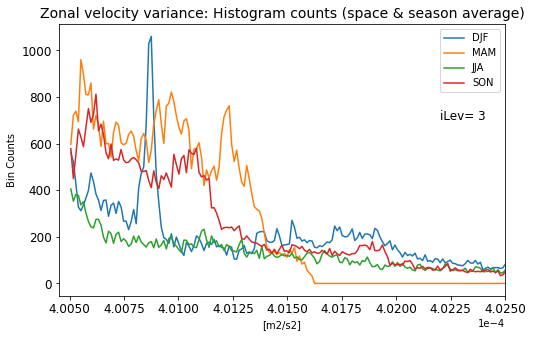

In [192]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(UP2seasonal_binCent,nDJF,'-')
ax1.plot(UP2seasonal_binCent,nMAM,'-')
ax1.plot(UP2seasonal_binCent,nJJA,'-')
ax1.plot(UP2seasonal_binCent,nSON,'-')

ax1.legend(['DJF','MAM','JJA','SON'])
ax1.set_title('Zonal velocity variance: Histogram counts (space & season average)', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0)) # Use scientific notation on x-axis
ax1.set_ylabel('Bin Counts')     # Specify axis labels
ax1.set_xlabel('[m2/s2]')
ax1.set_xlim([4.0045e-4, 4.025e-4])  # Zoom in on the x-axis to more clearly see differences
ax1.text(4.022e-4,700,'iLev= '+str(iLev),fontsize=12)

ax1.tick_params(labelsize=12)    # Set tick font size 


### Maps

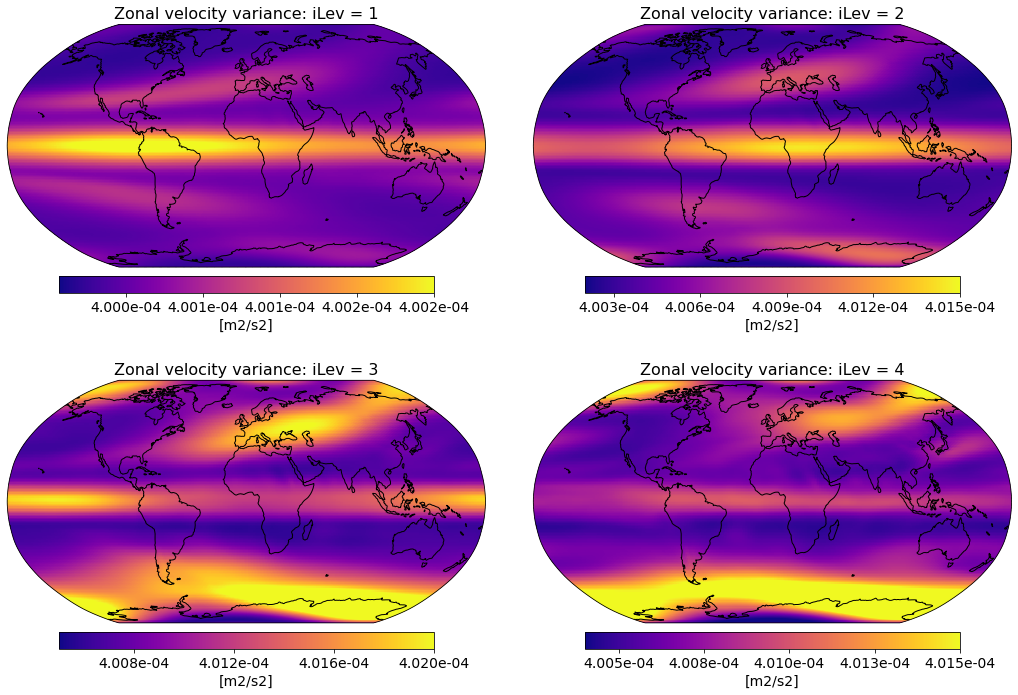

In [158]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by level
cMin = [ 4.00005e-4, 4.002e-4, 4.0050e-4, 4.004e-4 ]
cMax = [ 4.002e-4, 4.015e-4, 4.0200e-4, 4.015e-4 ]

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_timeMean[iLev+1,:,:]), dataDF.lon)
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,UP2_cyclic,
                                        vmin=cMin[iLev],
                                        vmax=cMax[iLev],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity variance: iLev = '+str(iLev+1), fontsize=16)


In [26]:
# Figure out reasonable values for cbar (WP3)

for iLev in range(4):
    levSel = iLev+1
    
    print('** iLev: ', str(levSel))
    print('      Min: %5.4e' % (np.nanmin(WP3_timeMean[levSel,:,:])))
    print('      Max: %5.4e' % (np.nanmax(WP3_timeMean[levSel,:,:])))
    

** iLev:  1
      Min: -1.4497e-10
      Max: -1.3548e-10
** iLev:  2
      Min: -7.6929e-10
      Max: -7.5284e-10
** iLev:  3
      Min: -6.4569e-10
      Max: -6.2427e-10
** iLev:  4
      Min: -1.0263e-09
      Max: -5.2920e-10


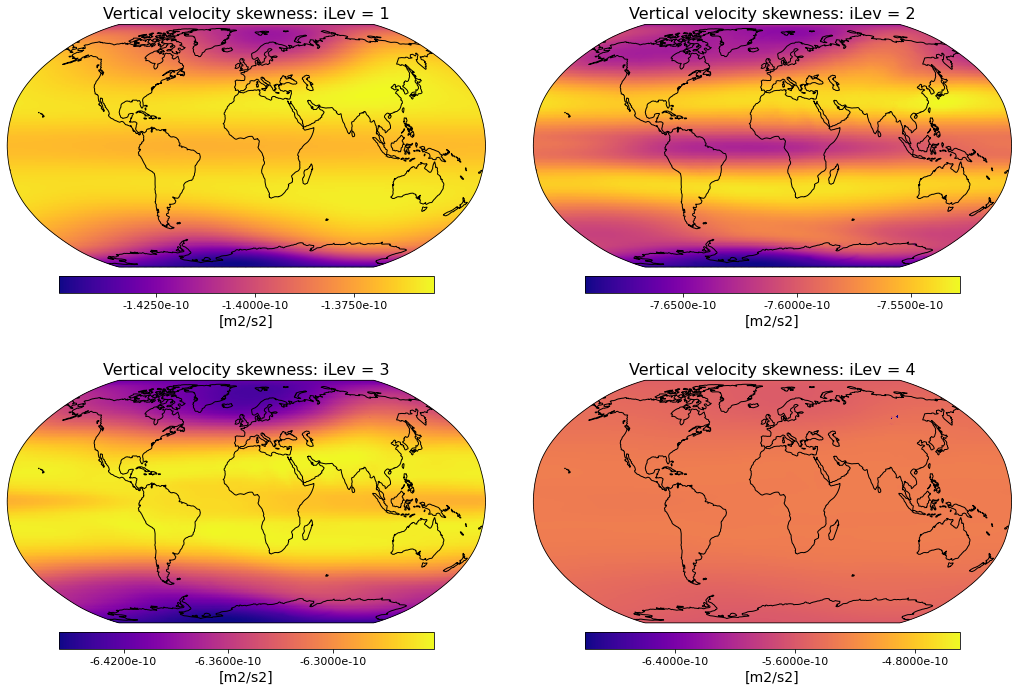

In [46]:
## --- Maps of WP3: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by level
cMin = [ -1.4497e-10, -7.6928e-10, -6.4569e-10, -0.7e-9 ]
cMax = [ -1.3547e-10, -7.5284e-10, -6.2426e-10, -0.45e-9 ]

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    WP3_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_timeMean[iLev+1,:,:]), dataDF.lon)
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,WP3_cyclic,
                                        vmin=cMin[iLev],
                                        vmax=cMax[iLev],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.4e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=11)
    
    # Set plot title 
    axs[iLev].set_title('Vertical velocity skewness: iLev = '+str(iLev+1), fontsize=16)


#### Seasonal

In [96]:
# Figure out reasonable bounds for level 1 by season 
print('Min value for season is %5.4e' % np.nanmin(UP2_SONmean[1,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_SONmean[1,:,:]))

Min value for season is 4.0001e-04
Max value for season is 4.0011e-04


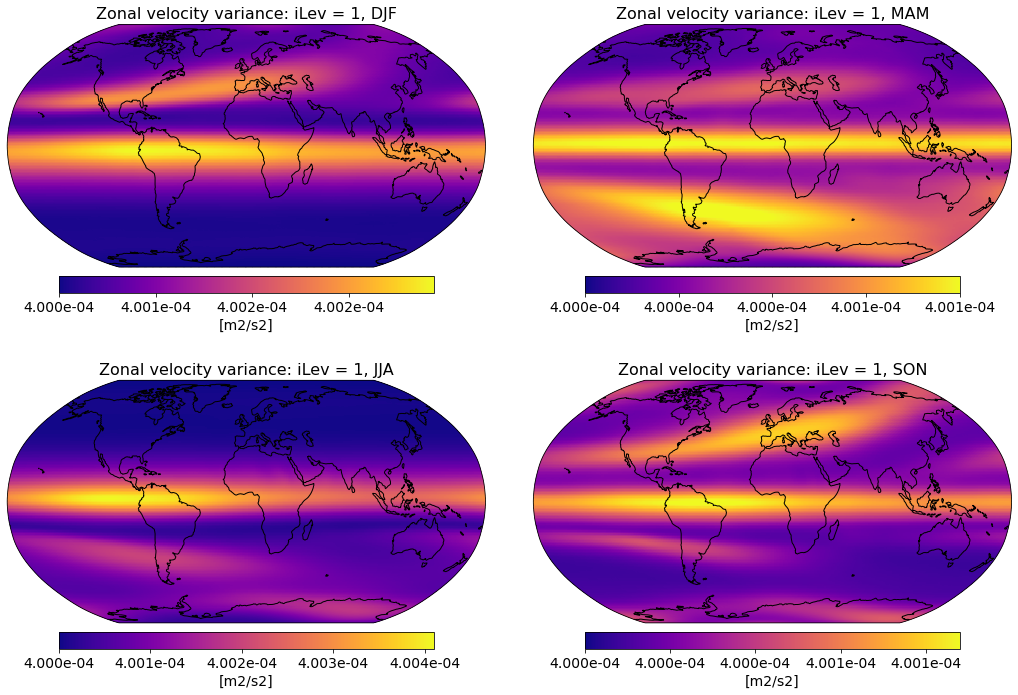

In [193]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by season now
cMin = [ 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
cMax = [ 4.0031e-04, 4.0008e-04, 4.0041e-04, 4.0011e-04 ]

# Specify level 
iLev = 1

# Get cyclic point for all seasons by level
UP2djf_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev,:,:]), dataDF.lon)
UP2mam_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev,:,:]), dataDF.lon)
UP2jja_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev,:,:]), dataDF.lon)
UP2son_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev,:,:]), dataDF.lon)


for iSeason in range(4):
    # Set global extent
    axs[iSeason].set_global()
    
    # Specify seasonal UP2 
    if iSeason==0:
        UP2seasonal = UP2djf_cyclic 
        season = 'DJF'
    elif iSeason==1:
        UP2seasonal = UP2mam_cyclic 
        season = 'MAM'
    elif iSeason==2:
        UP2seasonal = UP2jja_cyclic 
        season = 'JJA'
    elif iSeason==3: 
        UP2seasonal = UP2son_cyclic 
        season = 'SON'
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iSeason].pcolormesh(lon_cyclic,lat,UP2seasonal,
                                        vmin=cMin[iSeason],
                                        vmax=cMax[iSeason],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iSeason].coastlines()
    
    # Add colorbar 
    ax_position = axs[iSeason].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iSeason].set_title('Zonal velocity variance: iLev = '+str(iLev)+', '+season, fontsize=16)


In [107]:
# Figure out reasonable values for second level by season 
print('Min value for season is %5.4e' % np.nanmin(UP2_SONmean[2,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_SONmean[2,:,:]))

Min value for season is 4.0008e-04
Max value for season is 4.0139e-04


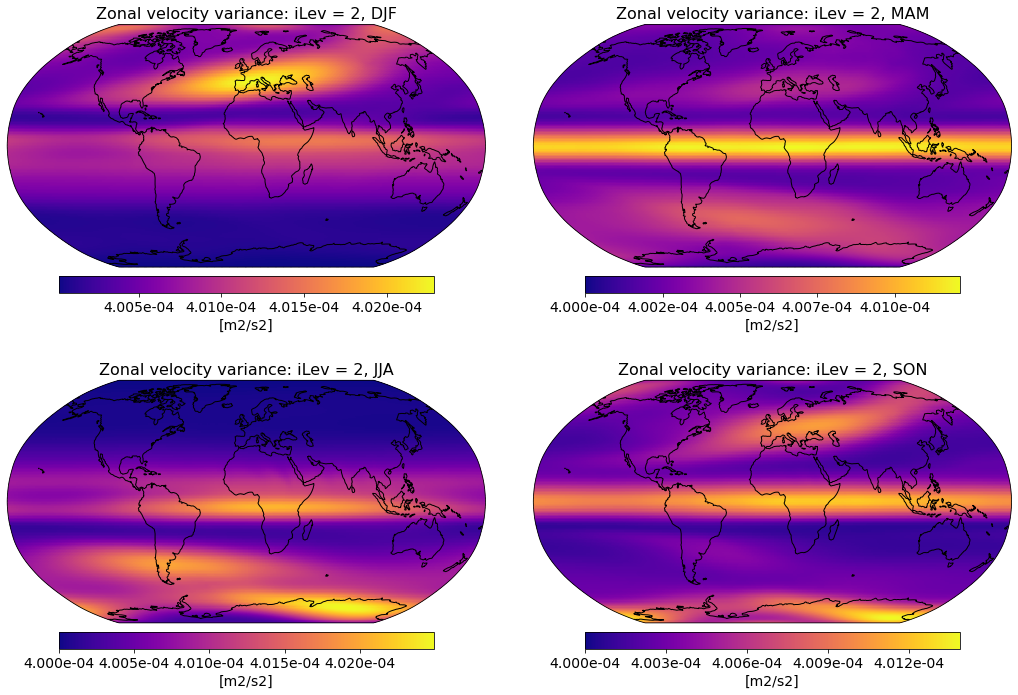

In [195]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by season now
cMin = [ 4.0002e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
cMax = [ 4.0228e-04, 4.0121e-04, 4.0249e-04, 4.0139e-04 ]

# Specify level 
iLev = 2

# Get cyclic point for all seasons by level
UP2djf_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev,:,:]), dataDF.lon)
UP2mam_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev,:,:]), dataDF.lon)
UP2jja_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev,:,:]), dataDF.lon)
UP2son_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev,:,:]), dataDF.lon)


for iSeason in range(4):
    # Set global extent
    axs[iSeason].set_global()
    
    # Specify seasonal UP2 
    if iSeason==0:
        UP2seasonal = UP2djf_cyclic 
        season = 'DJF'
    elif iSeason==1:
        UP2seasonal = UP2mam_cyclic 
        season = 'MAM'
    elif iSeason==2:
        UP2seasonal = UP2jja_cyclic 
        season = 'JJA'
    elif iSeason==3: 
        UP2seasonal = UP2son_cyclic 
        season = 'SON'
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iSeason].pcolormesh(lon_cyclic,lat,UP2seasonal,
                                        vmin=cMin[iSeason],
                                        vmax=cMax[iSeason],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iSeason].coastlines()
    
    # Add colorbar 
    ax_position = axs[iSeason].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iSeason].set_title('Zonal velocity variance: iLev = '+str(iLev)+', '+season, fontsize=16)


In [114]:
# Specify reasonable values at third level by season 
print('Min value for season is %5.4e' % np.nanmin(UP2_JJAmean[3,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_JJAmean[3,:,:]))


Min value for season is 4.0002e-04
Max value for season is 4.0731e-04


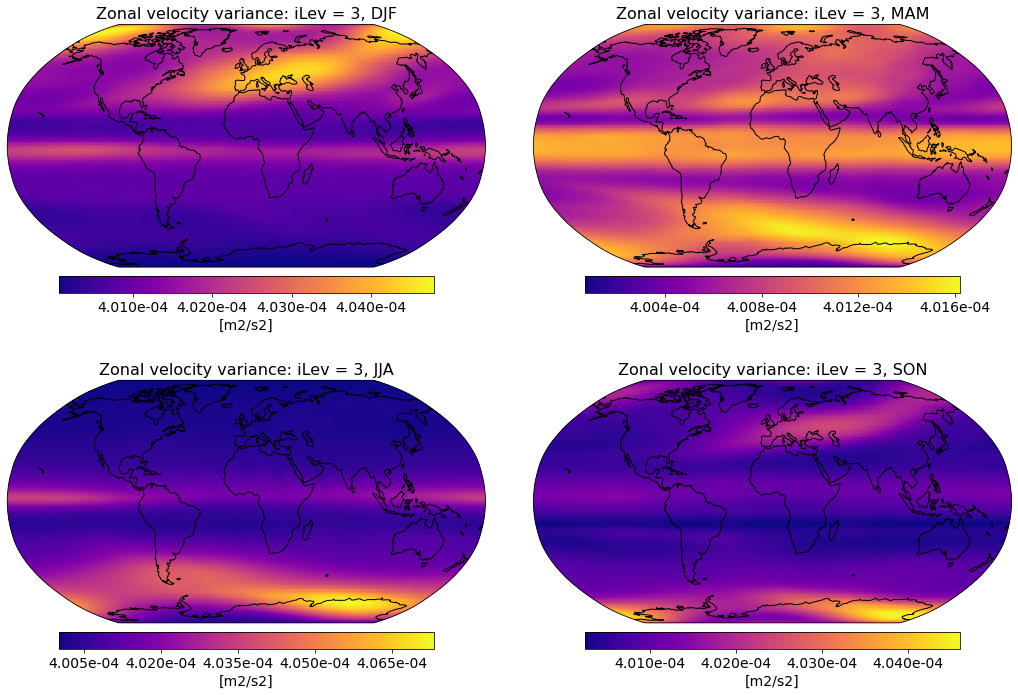

In [196]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by season now
cMin = [ 4.0007e-04, 4.0007e-04, 4.0002e-04,  4.0025e-04 ]
cMax = [ 4.0479e-04, 4.0162e-04, 4.0731e-04, 4.0460e-04 ]

# Specify level 
iLev = 3

# Get cyclic point for all seasons by level
UP2djf_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev,:,:]), dataDF.lon)
UP2mam_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev,:,:]), dataDF.lon)
UP2jja_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev,:,:]), dataDF.lon)
UP2son_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev,:,:]), dataDF.lon)

for iSeason in range(4):
    # Set global extent
    axs[iSeason].set_global()
    
    # Specify seasonal UP2 
    if iSeason==0:
        UP2seasonal = UP2djf_cyclic 
        season = 'DJF'
    elif iSeason==1:
        UP2seasonal = UP2mam_cyclic 
        season = 'MAM'
    elif iSeason==2:
        UP2seasonal = UP2jja_cyclic 
        season = 'JJA'
    elif iSeason==3: 
        UP2seasonal = UP2son_cyclic 
        season = 'SON'
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iSeason].pcolormesh(lon_cyclic,lat,UP2seasonal,
                                        vmin=cMin[iSeason],
                                        vmax=cMax[iSeason],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iSeason].coastlines()
    
    # Add colorbar 
    ax_position = axs[iSeason].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iSeason].set_title('Zonal velocity variance: iLev = '+str(iLev)+', '+season, fontsize=16)



In [117]:
# Specify reasonable ranges at the fourth level by season
print('--- DJF')
print('Min value for season is %5.4e' % np.nanmin(UP2_DJFmean[4,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_DJFmean[4,:,:]))

print('--- MAM')
print('Min value for season is %5.4e' % np.nanmin(UP2_MAMmean[4,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_MAMmean[4,:,:]))

print('--- JJA')
print('Min value for season is %5.4e' % np.nanmin(UP2_JJAmean[4,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_JJAmean[4,:,:]))

print('---- SON')
print('Min value for season is %5.4e' % np.nanmin(UP2_SONmean[4,:,:]))
print('Max value for season is %5.4e' % np.nanmax(UP2_SONmean[4,:,:]))



--- DJF
Min value for season is 4.0007e-04
Max value for season is 4.0398e-04
--- MAM
Min value for season is 4.0014e-04
Max value for season is 4.0124e-04
--- JJA
Min value for season is 4.0002e-04
Max value for season is 4.0627e-04
---- SON
Min value for season is 4.0027e-04
Max value for season is 4.0412e-04


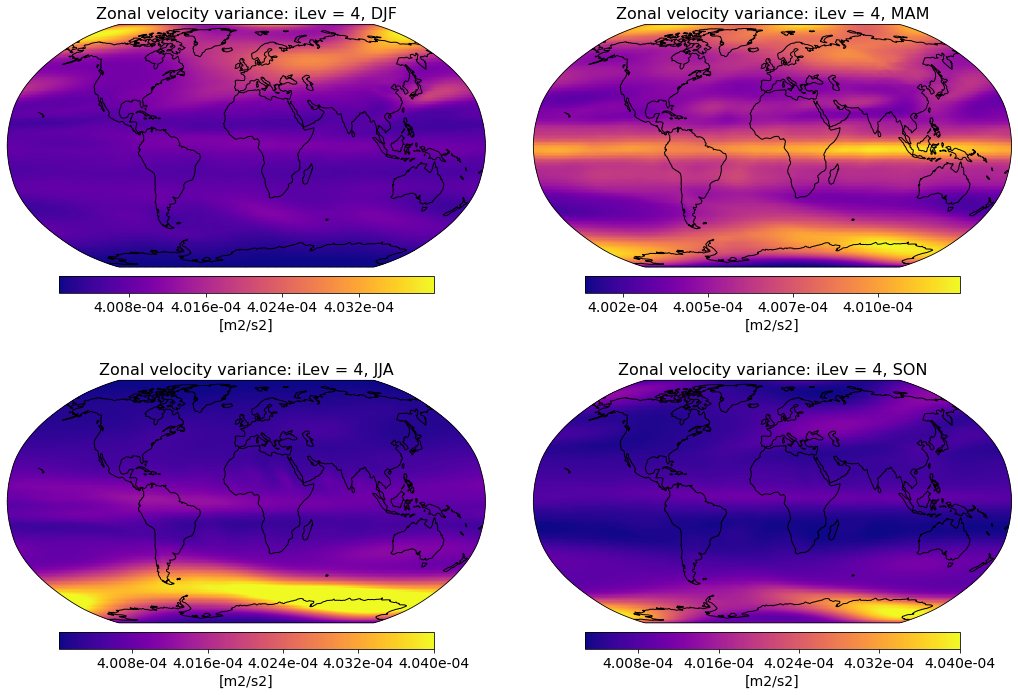

In [197]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by season now
cMin = [ 4.0007e-04, 4.0014e-04, 4.0002e-04, 4.0027e-04 ]
cMax = [ 4.0398e-04, 4.0124e-04, 4.0400e-04, 4.0400e-04 ]

# Specify level 
iLev = 4

# Get cyclic point for all seasons by level
UP2djf_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev,:,:]), dataDF.lon)
UP2mam_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev,:,:]), dataDF.lon)
UP2jja_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev,:,:]), dataDF.lon)
UP2son_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev,:,:]), dataDF.lon)


for iSeason in range(4):
    # Set global extent
    axs[iSeason].set_global()
    
    # Specify seasonal UP2 
    if iSeason==0:
        UP2seasonal = UP2djf_cyclic 
        season = 'DJF'
    elif iSeason==1:
        UP2seasonal = UP2mam_cyclic 
        season = 'MAM'
    elif iSeason==2:
        UP2seasonal = UP2jja_cyclic 
        season = 'JJA'
    elif iSeason==3: 
        UP2seasonal = UP2son_cyclic 
        season = 'SON'
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iSeason].pcolormesh(lon_cyclic,lat,UP2seasonal,
                                        vmin=cMin[iSeason],
                                        vmax=cMax[iSeason],
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iSeason].coastlines()
    
    # Add colorbar 
    ax_position = axs[iSeason].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iSeason].set_title('Zonal velocity variance: iLev = '+str(iLev)+', '+season, fontsize=16)


Make one *giant* plot to show all four levels and all four seasons 

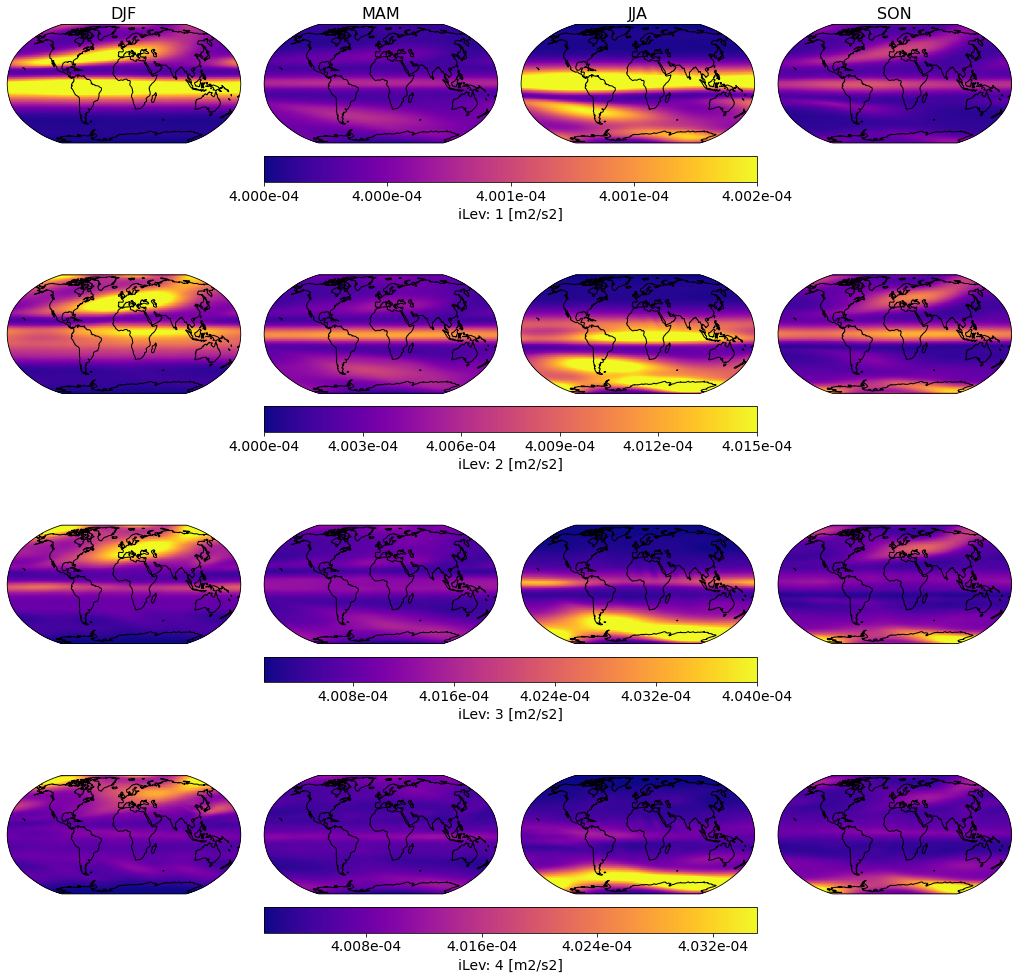

In [213]:
## --- Maps of UP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    #    Note: To vary by season, use commented out arrays. For constant by level, use single values 
    if iLev==0:
#         cMin = [ 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0031e-04, 4.0008e-04, 4.0041e-04, 4.0011e-04 ]
        cMin=4.0000e-4
        cMax=4.0020e-4
        
    
    elif iLev==1:
#         cMin = [ 4.0002e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0228e-04, 4.0121e-04, 4.0249e-04, 4.0139e-04 ]
        cMin=4.00e-4
        cMax=4.015e-4

    elif iLev==2:
#         cMin = [ 4.0007e-04, 4.0007e-04, 4.0002e-04, 4.0025e-04 ]
#         cMax = [ 4.0479e-04, 4.0162e-04, 4.0731e-04, 4.0460e-04 ]
        cMin = 4.0010e-4 
        cMax = 4.0400e-4

    elif iLev==3: 
#         cMin = [ 4.0007e-04, 4.0014e-04, 4.0002e-04, 4.0027e-04 ]
#         cMax = [ 4.0398e-04, 4.0124e-04, 4.0400e-04, 4.0400e-04 ]
        cMin = 4.0010e-4
        cMax = 4.0350e-4
        
    # Get cyclic point for all seasons by level
    UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma',
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

In [220]:
# Specify reasonable ranges at the fourth level by season

iLev = 4
print('Level: ', iLev)

print('--- DJF')
print('Min value for season is %6.5e' % np.nanmin(VP2_DJFmean[iLev,:,:]))
print('Max value for season is %6.5e' % np.nanmax(VP2_DJFmean[iLev,:,:]))

print('--- MAM')
print('Min value for season is %6.5e' % np.nanmin(VP2_MAMmean[iLev,:,:]))
print('Max value for season is %6.5e' % np.nanmax(VP2_MAMmean[iLev,:,:]))

print('--- JJA')
print('Min value for season is %6.5e' % np.nanmin(VP2_JJAmean[iLev,:,:]))
print('Max value for season is %6.5e' % np.nanmax(VP2_JJAmean[iLev,:,:]))

print('---- SON')
print('Min value for season is %6.5e' % np.nanmin(VP2_SONmean[iLev,:,:]))
print('Max value for season is %6.5e' % np.nanmax(VP2_SONmean[iLev,:,:]))
      


Level:  4
--- DJF
Min value for season is 4.00068e-04
Max value for season is 4.02909e-04
--- MAM
Min value for season is 4.00144e-04
Max value for season is 4.01217e-04
--- JJA
Min value for season is 4.00018e-04
Max value for season is 4.02241e-04
---- SON
Min value for season is 4.00167e-04
Max value for season is 4.02089e-04


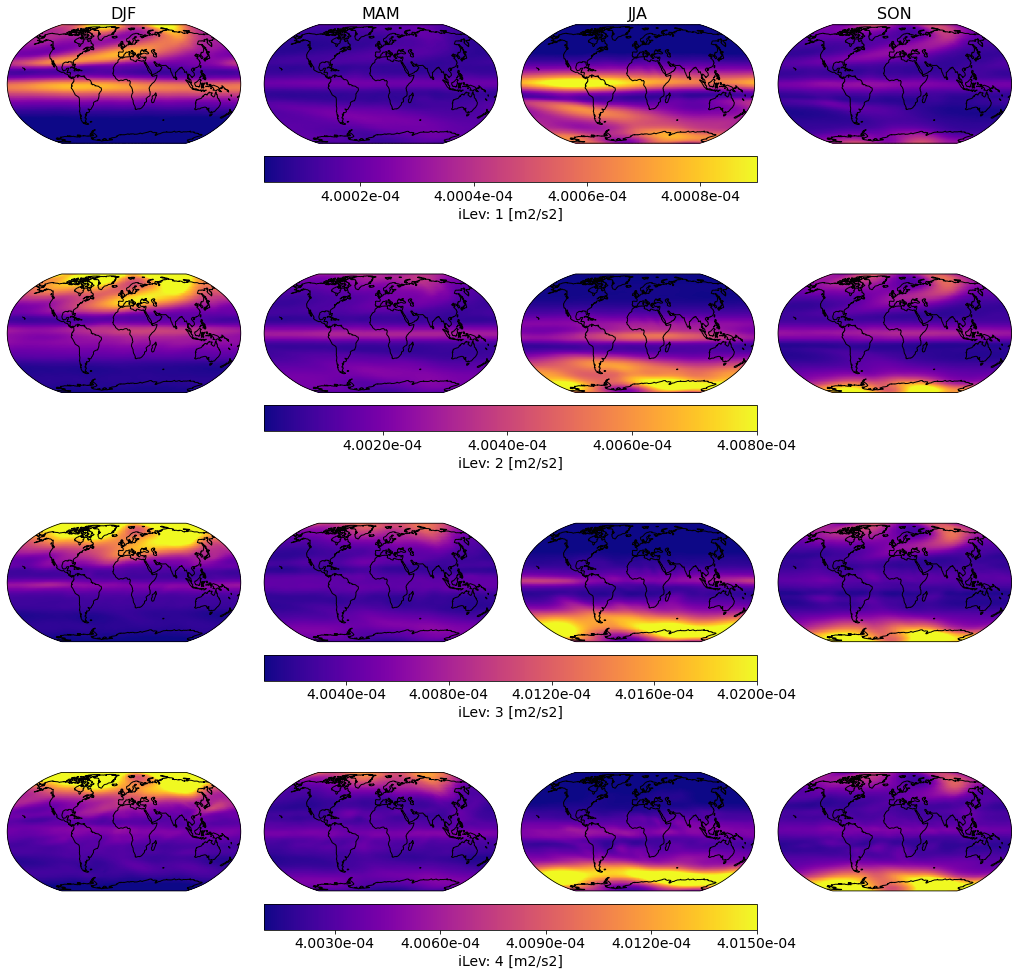

In [226]:
## --- Maps of VP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar ranges
    if iLev==0:
        cMin=4.00003e-04
        cMax=4.00090e-04
    
    elif iLev==1:
        cMin=4.00010e-4
        cMax=4.0080e-4

    elif iLev==2:
        cMin = 4.0008e-4
        cMax = 4.0200e-4

    elif iLev==3: 
        cMin = 4.0010e-4
        cMax = 4.0150e-4
        
    # Get cyclic point for all seasons by level
    VP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    VP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(VP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma',
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.4e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

### Attempt using discrete colorbar

In [33]:
# Set up new colorbar 
my_cmap = colors.ListedColormap(['darkmagenta','darkblue','dodgerblue','lightblue','green','yellowgreen','gold','darkorange','orangered','darkred'])

#my_cmap = colors.ListedColormap(['maroon','red','darkorange','gold','yellowgreen','green','c','darkblue','darkorchid','indigo'])
my_cmap.set_over('crimson')
my_cmap.set_under('indigo')


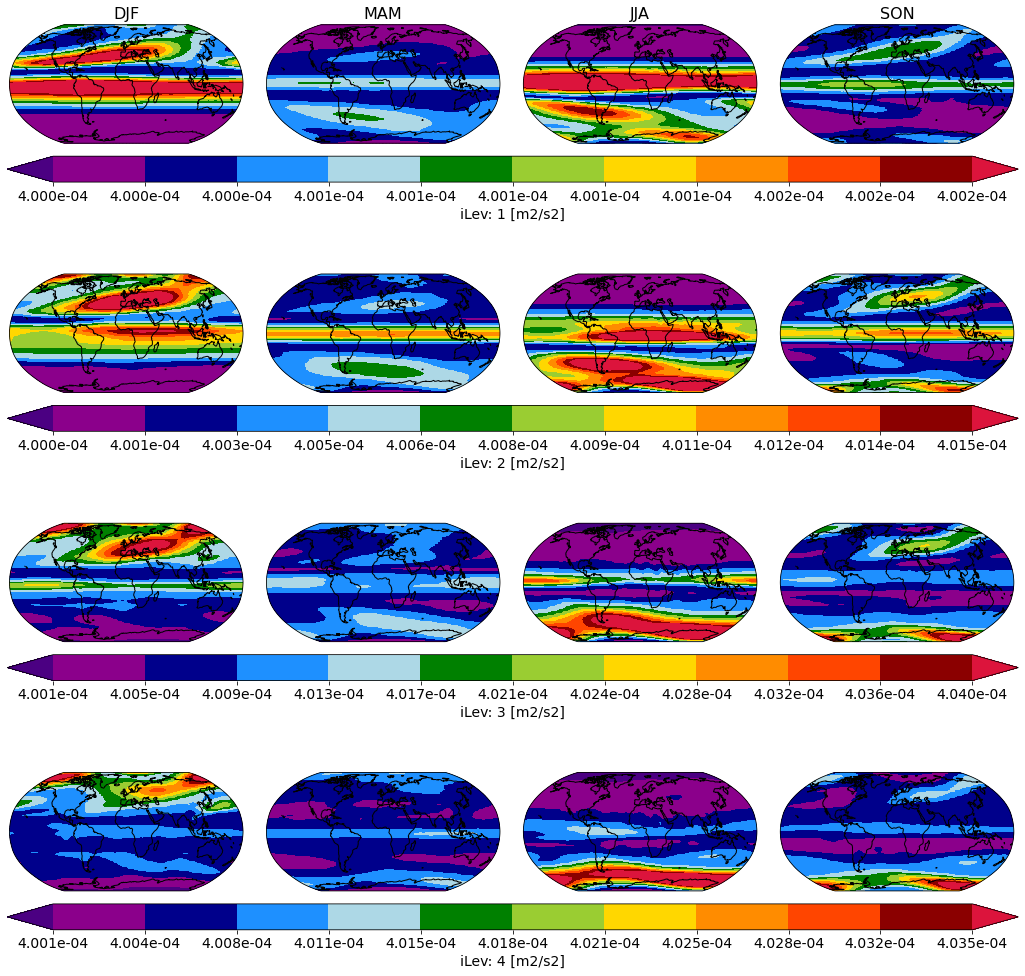

In [37]:
## --- Maps of UP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    #    Note: To vary by season, use commented out arrays. For constant by level, use single values 
    if iLev==0:
        cmin = 4.0000e-4
        cmax = 4.0020e-4
        bounds = np.linspace(4.0000e-4,4.0020e-4,11)
        norm = colors.BoundaryNorm(bounds, my_cmap.N)
    
    elif iLev==1:
        cmin = 4.0000e-4
        cmax = 4.015e-4
        bounds = np.linspace(4.0000e-4,4.015e-4,11)
        norm = colors.BoundaryNorm(bounds, my_cmap.N)

    elif iLev==2:
        cmin = 4.0010e-4
        cmax = 4.0400e-4
        bounds = np.linspace(4.0010e-4,4.0400e-4,11)
        norm = colors.BoundaryNorm(bounds, my_cmap.N)

    elif iLev==3: 
        cmin = 4.0010e-4
        cmax = 4.0350e-4
        bounds = np.linspace(4.0010e-4,4.0350e-4,11)
        norm = colors.BoundaryNorm(bounds, my_cmap.N)
        
    # Get cyclic point for all seasons by level
    UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
                                            vmin=cmin,
                                            vmax=cmax,
                                            norm=norm,
                                            cmap=my_cmap,
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.03, ax_position.width+0.6, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal',extend='both',ticks=bounds, cax=cbar_ax, format='%.3e')
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

### Can we zoom into the US? 

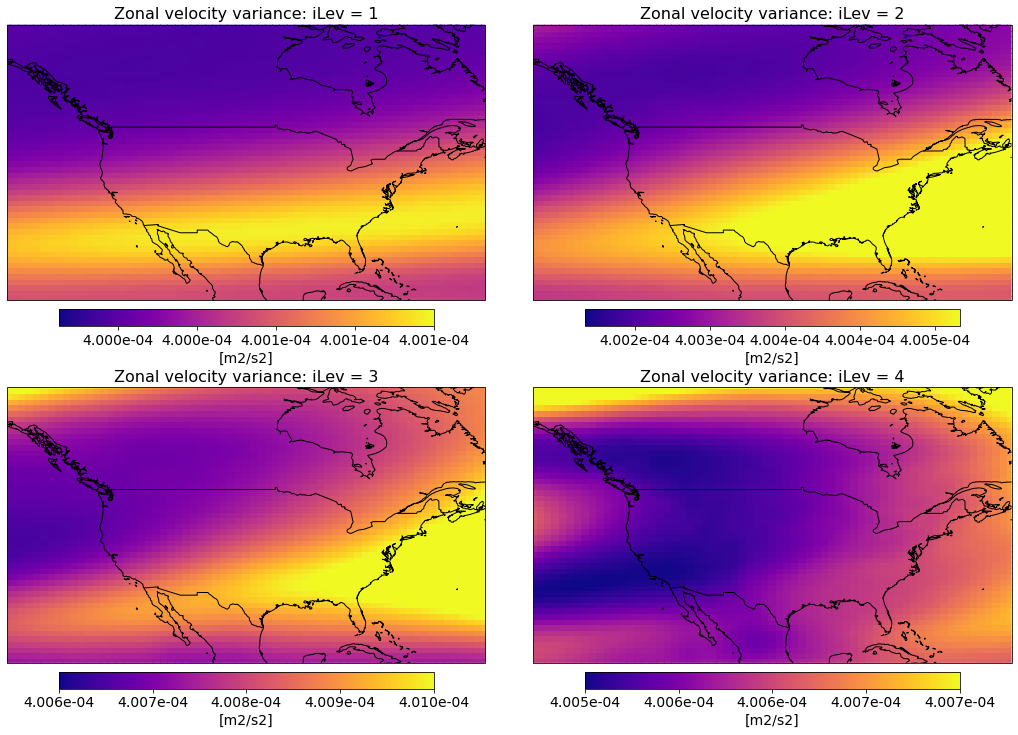

In [241]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.25,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by level
cMin = [ 4.00005e-4, 4.002e-4, 4.0060e-4, 4.005e-4 ]
cMax = [ 4.00100e-4, 4.005e-4, 4.0100e-4, 4.007e-4 ]

for iLev in range(4):
    # Set US extent
    axs[iLev].set_extent([220,300,20,60])
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_timeMean[iLev+1,:,:]), dataDF.lon)
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,UP2_cyclic,
                                        vmin=cMin[iLev],
                                        vmax=cMax[iLev],
                                        cmap='plasma')
   
    # Add coasts and continent outlines 
    axs[iLev].coastlines()
    axs[iLev].add_feature(cfeature.BORDERS)
    # Add states 
    states_provinces = cfeature.NaturalEarthFeature(    
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    axs[iLev].add_feature(states_provinces)
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity variance: iLev = '+str(iLev+1), fontsize=16)


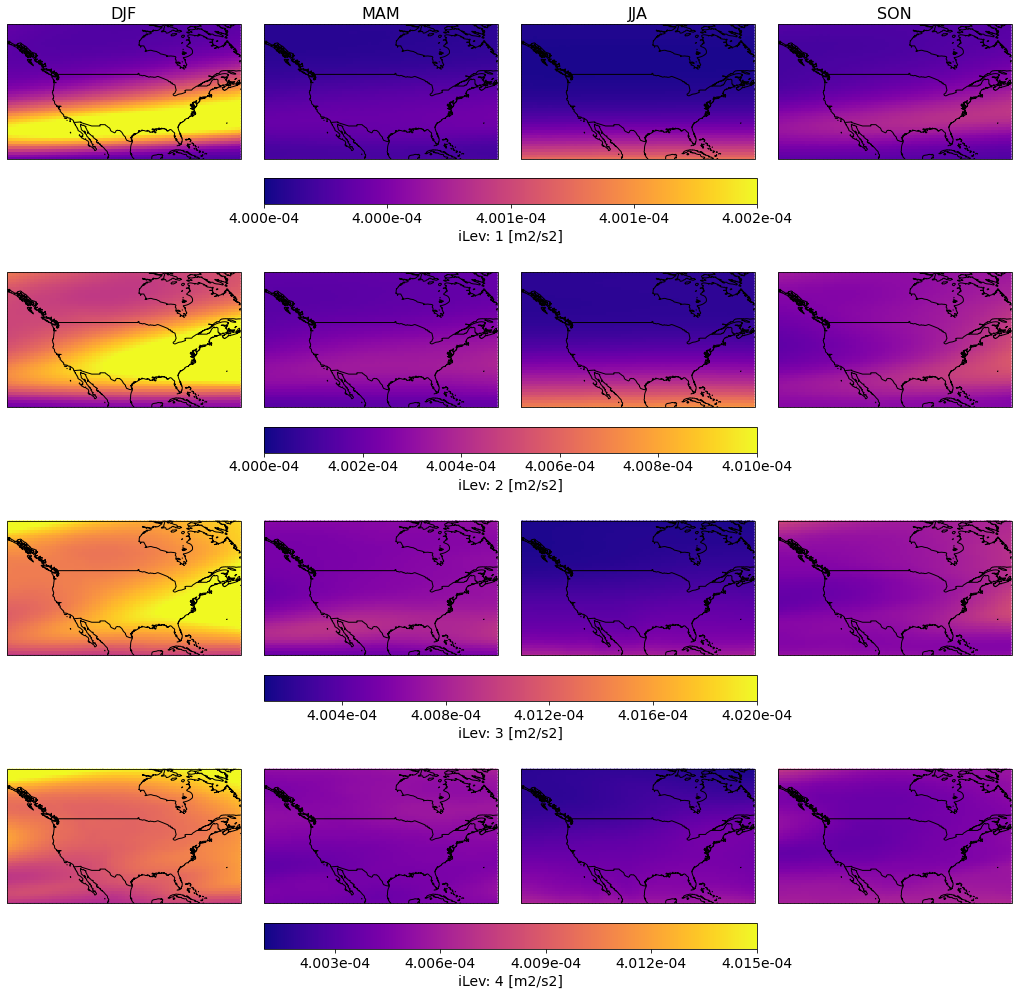

In [246]:
## --- Maps of UP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.06,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    #    Note: To vary by season, use commented out arrays. For constant by level, use single values 
    if iLev==0:
#         cMin = [ 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0031e-04, 4.0008e-04, 4.0041e-04, 4.0011e-04 ]
        cMin=4.0000e-4
        cMax=4.0020e-4
    
    elif iLev==1:
#         cMin = [ 4.0002e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0228e-04, 4.0121e-04, 4.0249e-04, 4.0139e-04 ]
        cMin=4.000e-4
        cMax=4.010e-4

    elif iLev==2:
#         cMin = [ 4.0007e-04, 4.0007e-04, 4.0002e-04, 4.0025e-04 ]
#         cMax = [ 4.0479e-04, 4.0162e-04, 4.0731e-04, 4.0460e-04 ]
        cMin = 4.0010e-4 
        cMax = 4.0200e-4

    elif iLev==3: 
#         cMin = [ 4.0007e-04, 4.0014e-04, 4.0002e-04, 4.0027e-04 ]
#         cMax = [ 4.0398e-04, 4.0124e-04, 4.0400e-04, 4.0400e-04 ]
        cMin = 4.0010e-4
        cMax = 4.0150e-4
        
    # Get cyclic point for all seasons by level
    UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set US extent
        axs[pltInd].set_extent([220,300,20,60])
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma')
        
        # Add coasts and continent outlines 
        axs[pltInd].coastlines()
        axs[pltInd].add_feature(cfeature.BORDERS)
        # Add states 
        states_provinces = cfeature.NaturalEarthFeature(    
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        axs[pltInd].add_feature(states_provinces)
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.035, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

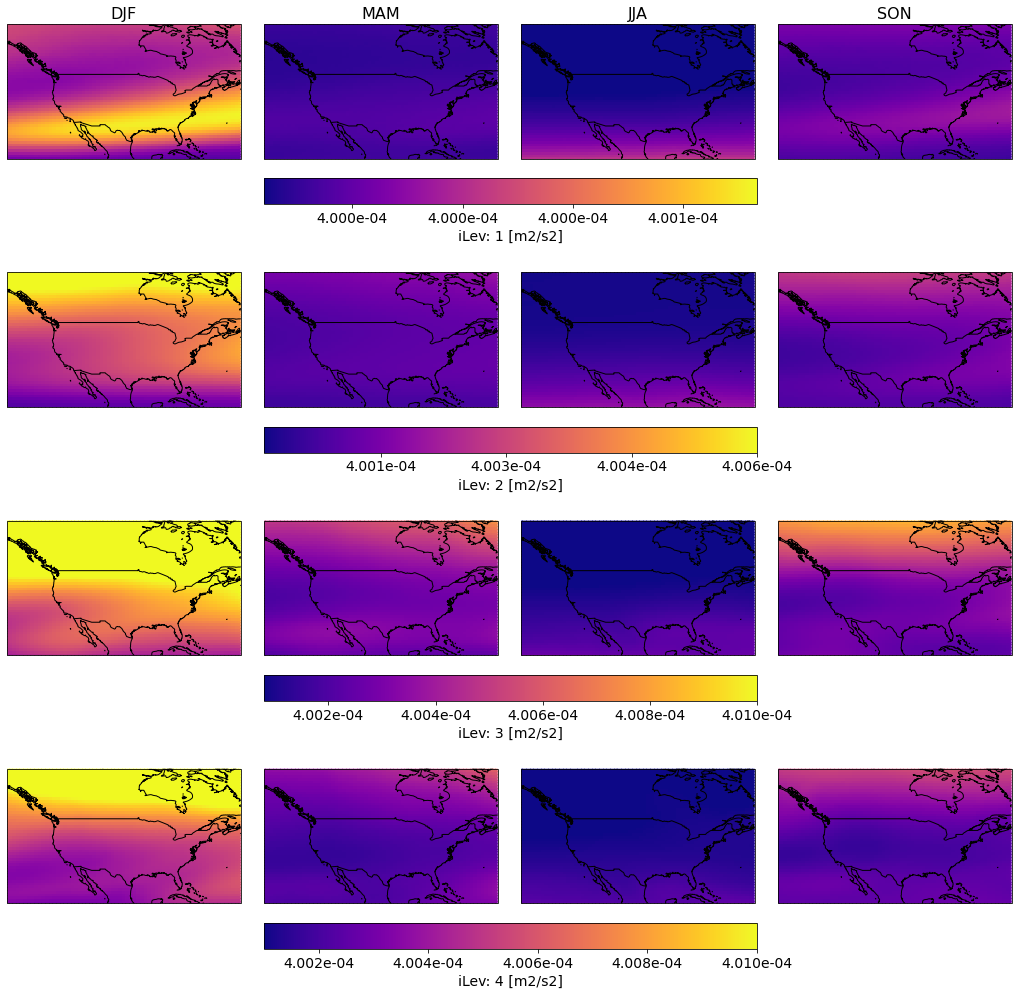

In [249]:
## --- Maps of VP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.06,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar ranges
    if iLev==0:
        cMin=4.00003e-04
        cMax=4.00070e-04
    
    elif iLev==1:
        cMin=4.00010e-4
        cMax=4.0060e-4

    elif iLev==2:
        cMin = 4.0008e-4
        cMax = 4.0100e-4

    elif iLev==3: 
        cMin = 4.0010e-4
        cMax = 4.0100e-4
        
    # Get cyclic point for all seasons by level
    VP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    VP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set US extent
        axs[pltInd].set_extent([220,300,20,60])
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(VP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma')
        
        # Add coasts and continent outlines 
        axs[pltInd].coastlines()
        axs[pltInd].add_feature(cfeature.BORDERS)
        # Add states 
        states_provinces = cfeature.NaturalEarthFeature(    
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        axs[pltInd].add_feature(states_provinces)
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.035, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

## Testing section

Read in 1951-59 data to see if I can get all this code set up. <br>

In [122]:
# Read in CLUBB data and surface pressure values 
fileName = dataDir+nameStart+decadeList[0]+nameEnd
dataDF   = xr.open_dataset(fileName,decode_times=True) 
dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

PSfile = dataDir+nameStart+decadeList[0]+'_PS.nc'
presDF = xr.open_dataset(PSfile,decode_times=True)
presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


<ipython-input-122-44017d059483>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-122-44017d059483>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


In [131]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(dataDF['time'].values) 
dates.month


Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
            ...
             4,  5,  6,  7,  8,  9, 10, 11, 12,  1],
           dtype='int64', length=108)

What does the dataframe containing CLUBB winds information look like?

In [21]:
dataDF

<xarray.Dataset>
Dimensions:    (ilev: 33, lat: 192, lon: 288, nbnd: 2, time: 108)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time       (time) float64 31.0 59.0 90.0 ... 3.224e+03 3.254e+03 3.285e+03
Dimensions without coordinates: nbnd
Data variables:
    P0         float64 1e+05
    hyai       (ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    hybi       (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    time_bnds  (time, nbnd) float64 0.0 31.0 31.0 ... 3.254e+03 3.285e+03
    PS         (time, lat, lon) float32 ...
    UP2_CLUBB  (time, ilev, lat, lon) float32 ...
    VP2_CLUBB  (time, ilev, lat, lon) float32 ...
    WP2_CLUBB  (time, ilev, lat, lon) float32 ...
    WP3_CLUBB  (time, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e20.FHIST.f09_f09.cesm2_1.001
    logname:           hannay
    host:              cheyenne5
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.001.cam.i.1950-01...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Fri Aug  7 13:56:59 2020: ncrcat -v UP2_CLUBB,VP2_CLUB...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [22]:
np.shape(dataDF.UP2_CLUBB)

(108, 33, 192, 288)

In [43]:
np.shape(presDF.PS)

(108, 192, 288)

**Maybe interpolate?** <br>
In my previous research, I mostly wanted data on a constant pressure level, but that was also typically for pressure levels higher in the atmosphere, not near the surface. I'm going to give interpolation a shot here using NCL's vinth2p function, but most likely we'll want to keep the sigma coordinates near the surface. (Right?)

In [48]:
p0   = 1000.
pnew = [1000,975,950,925,900,850,800,750,700,600,500]

hyai = dataDF.hyai.values
hybi = dataDF.hybi.values

PS  = presDF.PS
UP2 = dataDF.UP2_CLUBB


Some context: The final argument provided to vinth2p indicates whether or not to extrapolate when the pressure level requested is outside the range of PS. For a lot of regions on the globe, that could certainly cause issue for the lower levels. So let's just take a quick look at PS average in a given month.

Text(0.5, 1.0, 'Sfc Pressure (iTime=1)')

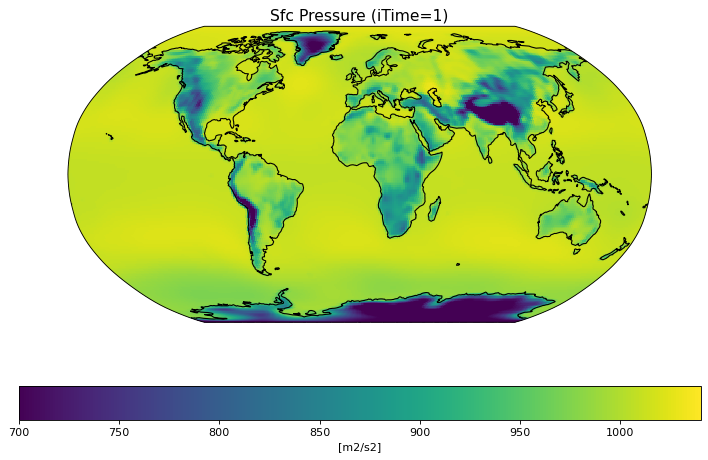

In [46]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
PS_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(PS[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,PS_cyclic/100.0,vmin=700,vmax=1040,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Sfc Pressure (iTime=1)', fontsize=14)



<br> Now do the actual interpolation <br>

In [49]:
# Interpolate to constant pressure levels 
UP2_new = Ngl.vinth2p(UP2,hyai,hybi,pnew,PS,1,p0,1,False)


In [51]:
# Check that arrays have expected size with new levels
print('Shape of not-interpolated data:', np.shape(UP2))
print('Shape of interpolated data:', np.shape(UP2_new))


Shape of not-interpolated data: (108, 33, 192, 288)
Shape of interpolated data: (108, 11, 192, 288)


In [52]:
# Average over time 
UP2_avg    = np.nanmean(UP2,0)
UP2new_avg = np.nanmean(UP2_new,0)


### Take a look at some summary statistics

In [58]:
len(dataDF.lat)

192

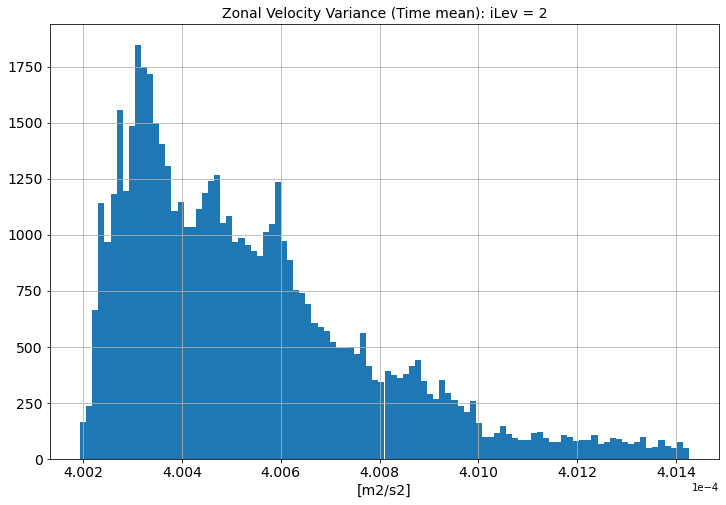

In [84]:
# --- For old data --- # 

# Specify level 
iLev = 2
UP2_reshape = np.squeeze(UP2_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): iLev = '+str(iLev), fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()


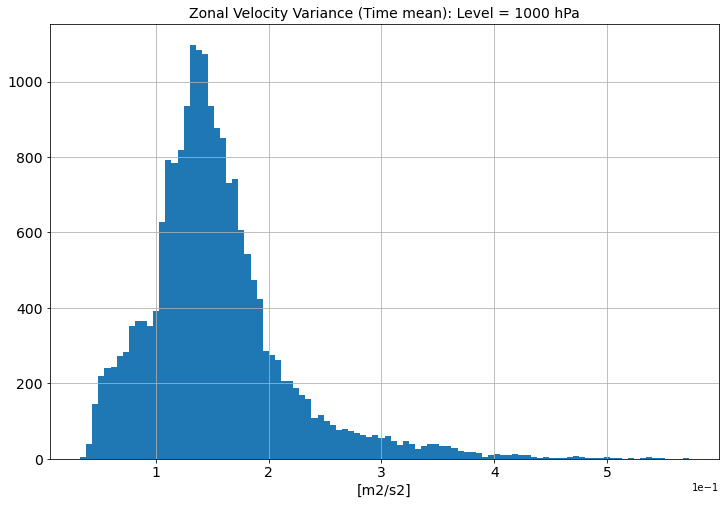

In [83]:
# --- For new data --- # 

# Specify level 
iLev = 0
UP2new_reshape = np.squeeze(UP2new_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))
# When data can't be extrapolated, seems like the fill value is 1e30. Set to NaN instead 
UP2new_reshape[UP2new_reshape==1e30] = np.nan 

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2new_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): Level = '+str(pnew[iLev])+' hPa', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()



Even if I mask out some of the crazy high values from vinth2p, we're still getting much bigger values of UP2_CLUBB after running the extrapolation. It feels like that would be a sign that this isn't working quite right. But, I do think it's better to stick with the sigma level anyway for right now, so I'm going to put a pin in the interpolation here.

### Try plotting

Text(0.5, 1.0, 'Zonal velocity variance (2nd lowest level; time mean, 1951-59)')

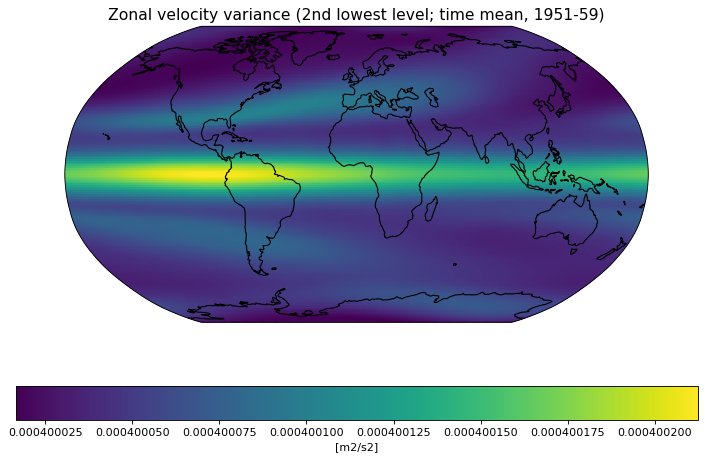

In [29]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_avg[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (2nd lowest level; time mean, 1951-59)', fontsize=14)


Text(0.5, 1.0, 'Zonal velocity variance (800 mb; time mean, 1951-59)')

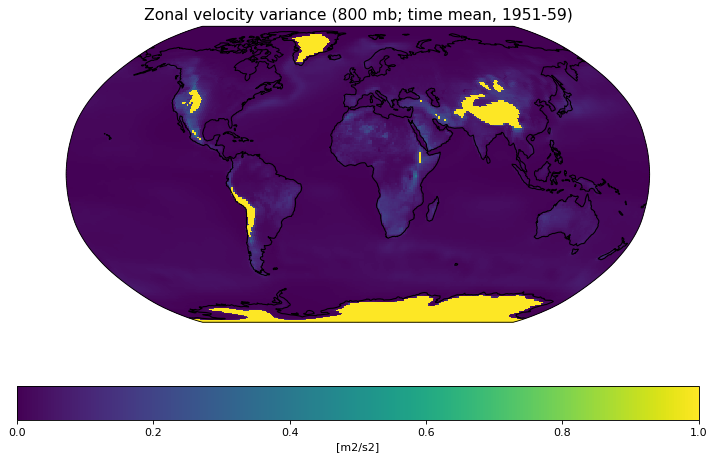

In [37]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2new_avg[6,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (800 mb; time mean, 1951-59)', fontsize=14)

